|                                        |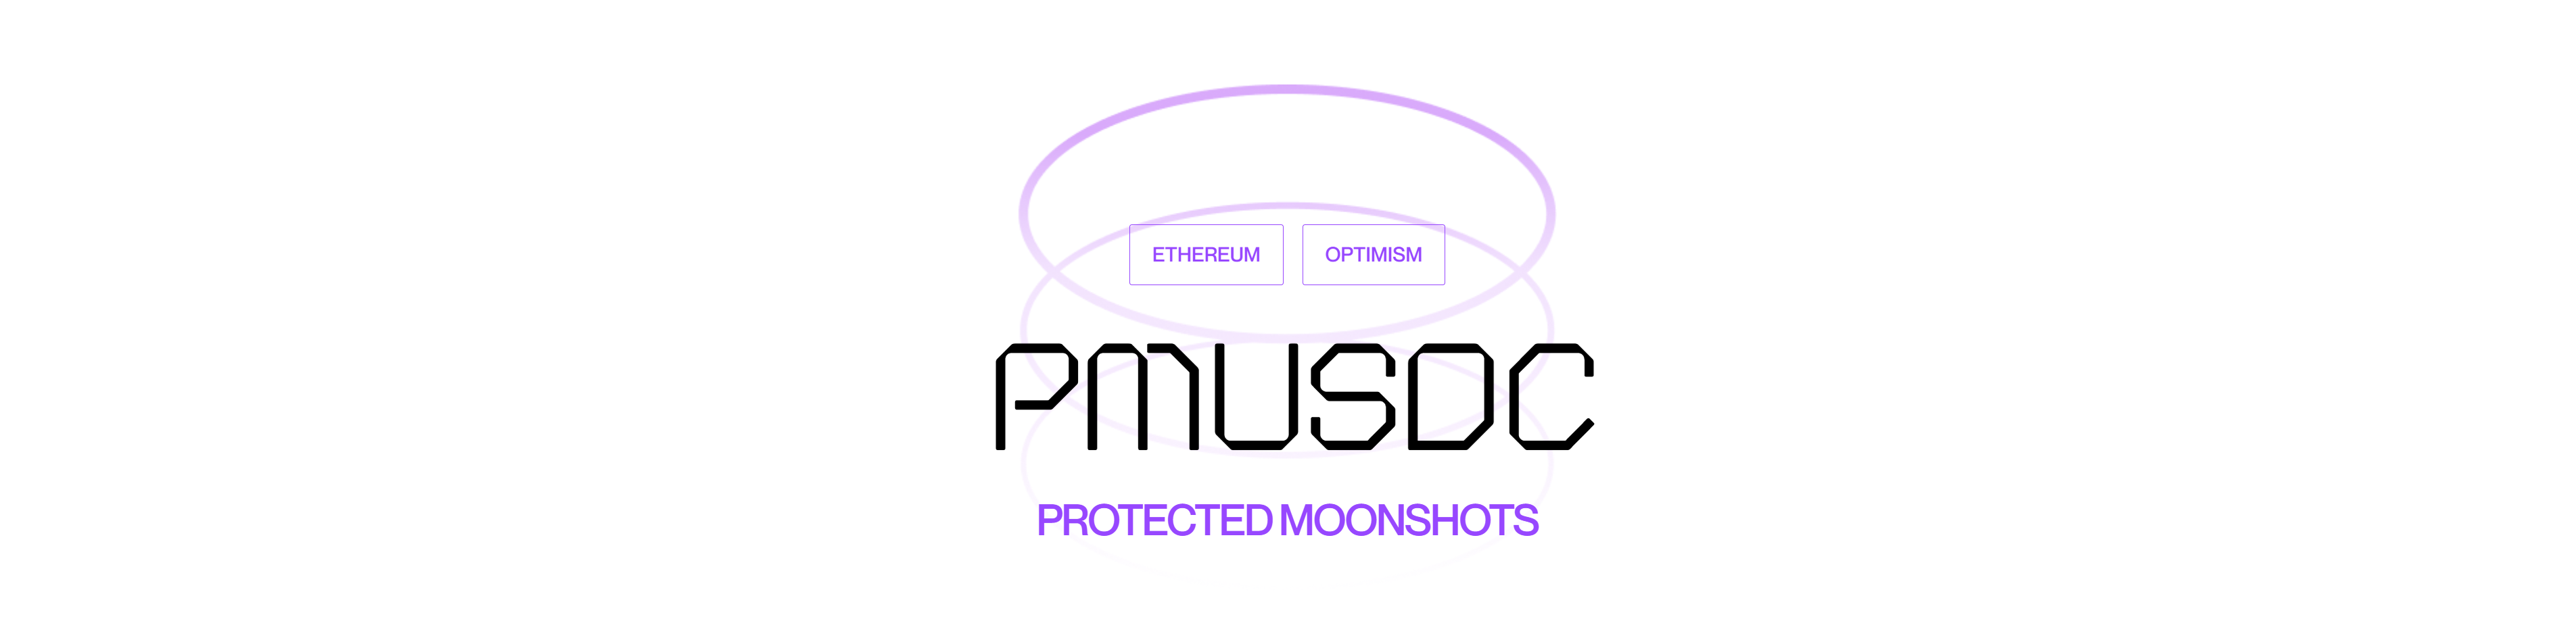|                                  |
|----------------------------------------|                                                                 |----------------------------------|


# PMUSDC V2.0 Vault Backtest

##  Strategy  Idea:

PMUDSC vaults are centred around the premise that the highly volatile nature of crypto assets presents significant trading opportunities.

The strategy looks to take advantage of these trading opportunities systematically in order to provide boosted stablecoin yields without having to risk base capital. So how does it work to provide the best place in Defi to park stables:

The vault receives single-sided USDC deposits.
The USDC is put to work in Defi in order to earn a base yield.
The base yield is harvested weekly and sent to decentralised derivative exchanges.
This yield is used to take derivative trades based on a systematic momentum tremd scanning strategy that looks to profit off crypto asset price movements, with PnL monitored to align with optimized stop-loss and take profit levels.
Any trading profits are compounded back into the strategy.

The upgraded architecture for PMUSDC V2 allows the vault to be able to deploy the weekly yield to either Perpetual Protocol to open a perpetual future position or to Lyra to purchase an option (can confirm the devs did something). The dual integration to these derivative platforms allows the construction of a more adaptive and dynamic weekly derivative trading strategy. Trading returns are maximised and return stability improved by using the yield to open a trade with the derivative instrument that is best suited to the current market regime. Strategy also employs volatility regime tracking, adjusting the position if one of volatility-based triggers is activated.

The end result is boosted stablecoin returns with a reduced reliance on unsustainable token emissions. The systematic trading strategy aims to provide returns through all market regimes - leaving you comfy and moisturised in your lane.

__Final Model General Parameters:__

|                                	| Parameter value 	|
|--------------------------------	|-----------------	|
| __Trade frequency__            	| 7 days          	|
| __Trade leverage__             	| 1              	|
| __Absolute signal confidence__ 	| 4               	|
| __Base Pool__                 	| https://curve.fi/#/ethereum/pools/3pool/deposit |

|                                	|![image.png](https://blog.brahma.fi/content/images/2022/06/PMUSDC-Charts--Twitter-Post---1-.png)|                                	|
|-----------------------------------|--------------------------------------------------------------------------------|---------------------------------|


## Implementation

### Imports

In [1]:
# General modules import
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from datetime import datetime,timedelta,timezone

sns.set(palette='deep')
%matplotlib inline

In [2]:
# Brahma modules imports
import sys
sys.path.append("../../")
from modules.defibulizer.offchain_defibulizer import DeFibulizer
from modules.backtesting.option_backtest import OptionBacktest
from modules.util.data_helpers import group_historical_data
from modules.util.backtest_helpers import ts_signal_prep, get_str_date
from modules.constants.pmusdcv2_const import PARAMS as pr

### Downloading the hourly data

For this backtest we gather 1year of historical data consisting of:
 * Hourly history of Deribit's Volatility Index: ETH DVOL
 * Price history data for ETH
 * 1-week at-the-money ETH implied volatility data from Deribit is procured automaticly by the backtest module


In [3]:
dt = DeFibulizer()

start_date = datetime(2021,7,30,8,tzinfo=timezone.utc)
end_date = datetime(2022,10,28,8,tzinfo=timezone.utc)

# Downloading the raw data
raw_data = dt.get_data(['ETHUSDT-PERP','ETH-DVOL'], start_date, end_date, frequency='h')
raw_data.index = pd.to_datetime(raw_data.index)

# Preprocessing only the needed columns for the backtest
hourly_prices = raw_data['ETHUSDT-PERP'][['open','high','low','close']]
hourly_dvol = raw_data['ETH-DVOL'][['open','close']].rename(columns={'open':'dvol_open','close':'dvol_close'}) / 100

# Getting the str date formats for file navigation
start_date_str = get_str_date(start_date)
end_date_str = get_str_date(end_date)

### Establishing the Hyperparameters

First we are going to set up all of the backtest hyperparameters:

In [4]:
#General Parameters

base_yield = pr['base_yield'] # Deposit yield
trade_freq = pr['trade_freq'] # Interest harvest and trade frequency (days)
is_usd = pr['is_usd'] # Whether the asset conversion is occuring in the strategy
historical_vol = pr['historical_vol'] # Whether to use historical vol provided by Deribit API

In [5]:
is_usd

True

In [6]:
# Signal Parameters

short_window = pr['short_window'] 
long_window = pr['long_window']
confidence = pr['confidence']

In [7]:
# Option Parameters

option_rate = pr['option_rate']
strike_rounding = pr['strike_rounding']
otm_percentage = pr['otm_percentage'] # % OTM of strike to buy/sell
bid_offer_spread = pr['bid_offer_spread'] 

In [8]:
# Volatility Parameters

volatility_bounds = {'rv_start': pr['rv_start'], 'dvol_open': pr['dvol_open'],
                     'sigma_open': pr['sigma_open'], 'dvol_premium': pr['dvol_premium']}

Next we will construct a TS position signal based on the given hyperparameters

In [9]:
tr_scan_labels_short = pd.read_csv(f'ts_data/ts_{short_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')
tr_scan_labels_long = pd.read_csv(f'ts_data/ts_{long_window}_{start_date_str}_{end_date_str}_open.csv').set_index('time')

In [10]:
positions = ts_signal_prep(tr_scan_labels_short, tr_scan_labels_long, confidence)

### Running The Backtest

In [11]:
backtest = OptionBacktest(price_data=hourly_prices, 
                          position_data=positions, rate=base_yield,
                          option_rate=option_rate, bid_offer_spread=bid_offer_spread,
                          trade_freq=trade_freq, strike_otm=0, 
                          volatility_bounds=volatility_bounds,
                          strike_rounding=strike_rounding, is_usd=is_usd,
                          dvol_data=hourly_dvol, historical_vol=historical_vol)

Backtest results record every valuable parameter for further reseach during each epoch.

In [12]:
backtest.backtest_results.tail(1)

,position_open_time,position_close_time,open,close,high,low,position,rv_start,rv_end,dvol_open,...,put_payoff,option_price,option_payoff,position_return,vault_balance_start,vault_balance_end,invested_yield,trade_profit,benchmark,transaction_fee
time,,,,,,,,,,,,,,,,,,,,,
2022-10-28 08:00:00+00:00,2022-10-21 08:00:00+00:00,2022-10-28 08:00:00+00:00,1284.16,1493.22,1595.0,1248.0,-1,0.386714,0.71093,0.7567,...,0.0,46.133618,0.0,-1.0,1.097282,1.097282,0.001157,-0.001157,1.0698,0.0


### Backtest Metrics

Strategy metrics:

In [13]:
backtest.strategy_metrics

,0
Strategy Yield,9.728240
Strategy APY,7.904195
Benchmark APY,5.671211
Trading Boost,1.393740
Sharpe Ratio,5.745749
Max Drawdown,0.000000


Signal metrics:

In [14]:
backtest.signal_metrics

,0
Epochs,65.000000
% Trades,0.738462
% Longs,0.562500
% Shorts,0.437500
Trade Hit Rate %,0.437500
Signal Hit Rate %,0.604167


### __Backtest Performance Visualisation__

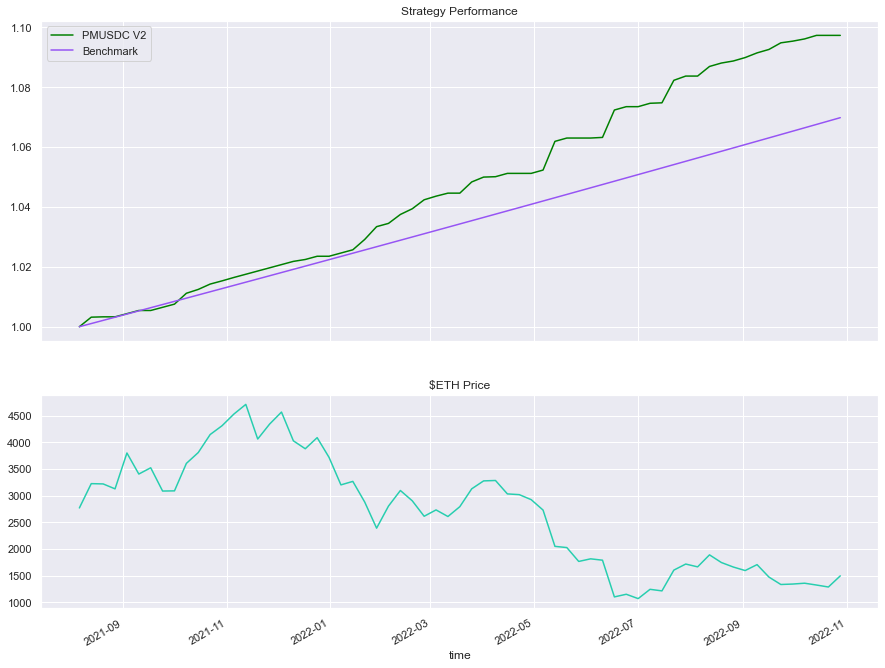

In [15]:
fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}, sharex=True);

backtest.backtest_results.vault_balance_end.plot(figsize = (15,12), ax=axs[0], title='Strategy Performance', legend = True, color='green');
backtest.backtest_results.benchmark.plot(figsize = (15,12), ax=axs[0], legend = True, color='#9654F4');
axs[0].legend(['PMUSDC V2', 'Benchmark']);
backtest.backtest_results.close.plot(ax=axs[1], title='$ETH Price', legend=False, color='#27CEAF');

### Volatility analysis plot

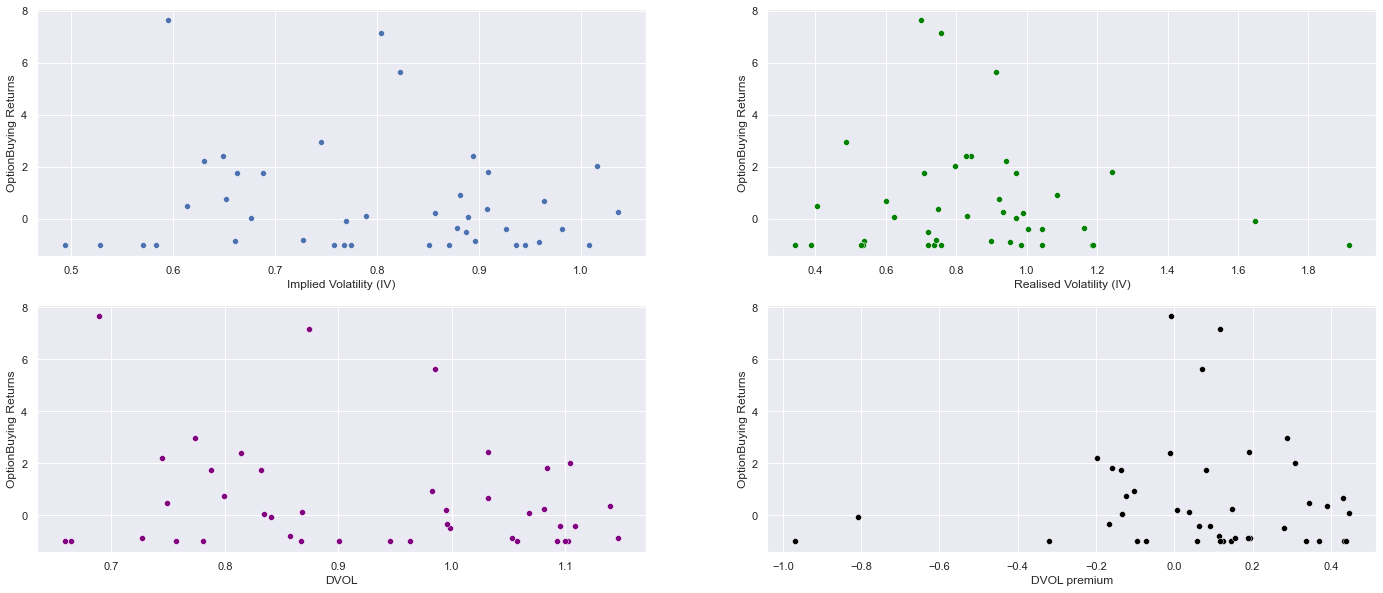

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,10))

# Plotting the absolute price move against the option buying strategy returns
# sns.scatterplot(x=abs(weekly_data.price_change), y=lyra_eth.optionReturns, ax=axes[0,0]);
# axes[0,0].set_xlabel('Abs Price Move');
# axes[0,0].set_ylabel('OptionBuying Returns');
sns.scatterplot(x=backtest.backtest_results.sigma_open, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[0,0]);
axes[0,0].set_xlabel('Implied Volatility (IV)');
axes[0,0].set_ylabel('OptionBuying Returns');


# Plotting the Implied Volatility (IV) against the option buying strategy returns
sns.scatterplot(x=backtest.backtest_results.rv_start, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[0,1], color="green");
axes[0,1].set_xlabel('Realised Volatility (IV)');
axes[0,1].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the option buying strategy returns
sns.scatterplot(x=backtest.backtest_results.dvol_open, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[1,0], color="purple");
axes[1,0].set_xlabel('DVOL');
axes[1,0].set_ylabel('OptionBuying Returns');

# Plotting the DVOL-RV against the enhanced perp strategy returns
sns.scatterplot(x=backtest.backtest_results.dvol_premium, y=backtest.backtest_results.position_return.loc[backtest.backtest_results.position_return!=0], ax=axes[1,1], color="black");
axes[1,1].set_xlabel('DVOL premium');
axes[1,1].set_ylabel('OptionBuying Returns');